【このノートブックについて】

特異値分解により，時系列の変化点検知を行う。

【参考資料】
- 井手剛「入門 機械学習による異常検知」（コロナ社，2015）第５章
- 井手剛，杉山将「異常検知と変化検知」（講談社，2015）第9章
- [Decomposing Time Series Data With Singular-Spectrum Analysis](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# データの準備
- 周波数の変化するデータ
- 変化点検知ライブラリ [ruptures](http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/index.html#)のサンプルデータ生成を使用。

## データ生成

(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x11989fc90>])

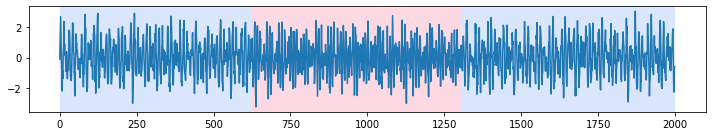

In [2]:
# creation of data
n = 2000  # number of samples, dimension
n_bkps, sigma = 2, 0.5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_wavy(n, n_bkps, noise_std=sigma)
rpt.display(signal, bkps)

## スペクトル（ピリオドグラム）

In [3]:
def display_periodogram(signal, NFFT=100, Fs=1):
    '''
    NFFT = 100  # the length of the windowing segments
    Fs = 1  # the sampling frequency
    '''
    t = np.arange(signal.shape[0])

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    ax1.plot(t, signal)
    Pxx, freqs, bins, im = ax2.specgram(signal, NFFT=NFFT, Fs=Fs, noverlap=80)
    
    return fig, (ax1, ax2)

(<Figure size 432x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1282d9410>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10c71da90>))

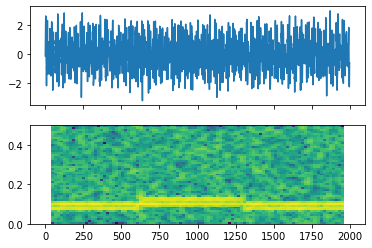

In [4]:
display_periodogram(signal)

# 部分空間法（プロセス）
- 時系列全体から一部分(長さLm)を抜き出し，前半から長さL_train, 後半から長さL_target取り出す。
- それぞれ長さLsのスライド窓により，履歴行列X, Zを作り出す。
- X, Zそれぞれ特異値分解を行い，左特異行列$U_m$, $Q_r$を作成する。
- 行列$U_m^T Q_r$をさらに特異値分解し，その第一特異値（を１から引いた値）を異常度とする。

## 時系列windowを切り出す

In [5]:
Lm = 200 # The total window length
L_train = 150 # The test window length
L_target = 50 # The target window length

In [6]:
index_target = 760
window_main = signal[index_target-Lm:index_target]
window_train = window_main[-L_train:]
window_target = window_main[:L_target]

## 履歴行列とテスト行列を作る

In [7]:
Ls = 30 # The sliding window width

In [8]:
# 履歴行列
K_x = window_train.shape[0] - Ls + 1
X = np.column_stack([window_train[i:i+Ls] for i in range(0,K_x)])

# テスト行列
K_z = window_target.shape[0] - Ls + 1
Z = np.column_stack([window_target[i:i+Ls] for i in range(0,K_z)])

In [9]:
X.shape

(30, 121)

In [10]:
Z.shape

(30, 21)

## それぞれ特異値分解を行い，左特異行列を計算する。

In [11]:
U_x, s_x, V_x = np.linalg.svd(X)
U_z, s_z, V_z = np.linalg.svd(Z)

In [12]:
U_x.shape, U_z.shape

((30, 30), (30, 30))

In [13]:
V_x.shape, V_z.shape

((121, 121), (21, 21))

## 各左特異行列同士を掛け合わせ，できた行列から特異値を取り出す

In [14]:
r = 3
m = 2

In [15]:
Ur = U_x[:, :r]
Qm = U_z[:, :m]

In [16]:
Ur.shape, Qm.shape

((30, 3), (30, 2))

In [17]:
U, s, V = np.linalg.svd(Ur.T.dot(Qm))

In [18]:
s

array([0.61195445, 0.406843  ])

## クラスにしてまとめる

In [19]:
class ChangePointSST():
    '''
    Change point detection based on singular spectrum transform.
    
    Parameters
    ========
    L_train: int (default 150)
        Data length of the reference term
        from which to create a train trajectory matirx.
    
    L_target: int (default None)
        Data length of the target term.
        from which to create a target trajectory matirx.
        If None, it is set the same as L_train.
        
    w: int (default 20)
        The length of a sliding window.
        
    d_train: int (default 3)
        The number of the left singular vectors to select
        from the train trajectory matrix.
        
    d_test: int (default 2)
        The number of the left singular vectors to select
        from the target trajectory matrix
    '''
    
    def __init__(self, L_train=150, L_target=None, w=20,
                            d_train=3, d_target=2):
        
        self.L_train = L_train
        if L_target is None:
            self.L_target = L_train
        else:
            self.L_target = L_target
        
        self.w = w
        self.r, self.m = d_train, d_target
        
    def _stack_svd(self, X):
        
        # Stack sliding windows into a matrix.
        K = X.shape[0] - self.w + 1 # The number of sliding windows to stack
        Z = np.column_stack([X[i:i+self.w] for i in range(0,K)])
        
        # Left singular matrix
        U, s, V = np.linalg.svd(Z)
        
        return U, s, V
    
    def score(self, X):
        
        window_train = X[:self.L_train]
        window_target = X[-self.L_target:]
        
        U_train, _, _ = self._stack_svd(window_train)
        Ur = U_train[:, :self.r]
        
        U_target, _, _ = self._stack_svd(window_target)
        Qm = U_target[:, :self.m]
        
        _, s, _ = np.linalg.svd(Ur.T.dot(Qm))
        
        return 1-s[0]


# サンプル時系列全体で実行

In [20]:
Lm = 200
L_train, L_target = 150, 50
w = 30

sst = ChangePointSST(L_train=L_train, L_target=L_target, w=w)

Kw = signal.shape[0] - Lm + 1
sst_results = np.array([sst.score(signal[i:i+Lm]) for i in range(0, Kw)])

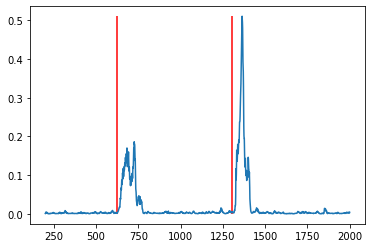

In [21]:
t_results = Lm + np.arange(0, sst_results.shape[0])# - L_target
plt.plot(t_results, sst_results)
plt.vlines(bkps[:-1], 0, sst_results.max(), linestyles='solid', colors='red')

# 【参考】分解した時系列を表示してみる
- [Decomposing Time Series Data With Singular-Spectrum Analysis](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition)の方法を使って特異値分解後の履歴行列・テスト行列を時系列として再構成した。
- ぱっと見ではそこまで大きな違いがあるようには見えない。

In [22]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [23]:
def display_1Dts(X, n_cols=2, unit_width=5, unit_height=2):
    
    
    n_comp_max = X.shape[0]

    n_cols = 2
    n_rows = int(np.ceil(n_comp_max / n_cols))
    
    t = np.arange(X.shape[1])
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(unit_width*n_cols, unit_height*n_rows))
    
    for ax, X_i in zip(axes.flatten(), X):

        ax.plot(t, X_i)
    
    return fig, axes

## 履歴行列とテスト行列の２次元プロット

In [24]:
X.shape, Z.shape

((30, 121), (30, 21))

Text(0.5, 1.05, 'test')

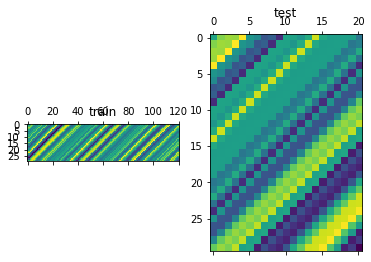

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=1)

axes[0].matshow(X)
axes[0].set_title('train')
axes[1].matshow(Z)
axes[1].set_title('test')

## 特異値分解後の各成分から時系列を再構成

### 履歴行列

In [26]:
X_decomposed = np.array([np.outer(ut_i, v_i) * s_i for ut_i, v_i, s_i in zip(U_x.T, V_x, s_x)])

In [27]:
signal_decomposed_X = np.array([X_to_TS(X_i) for X_i in X_decomposed])

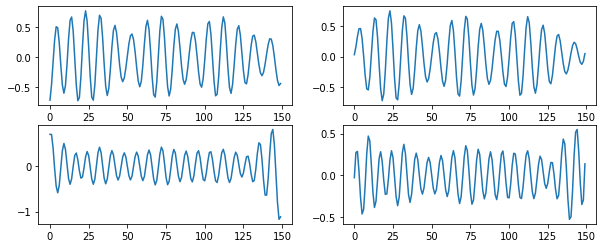

In [28]:
display_1Dts(signal_decomposed_X[:4]);

### テスト行列

In [29]:
Z_decomposed = np.array([np.outer(ut_i, v_i) * s_i for ut_i, v_i, s_i in zip(U_z.T, V_z, s_z)])

In [30]:
signal_decomposed_Z = np.array([X_to_TS(Z_i) for Z_i in Z_decomposed])

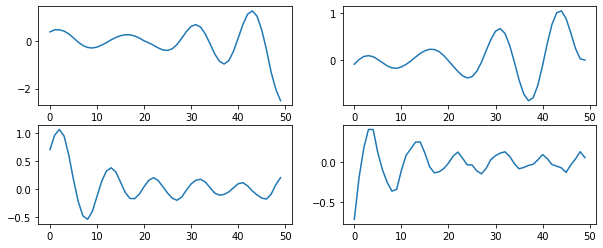

In [31]:
display_1Dts(signal_decomposed_Z[:4]);

### 主なn成分までの累積和

Text(0.5, 1.0, 'test')

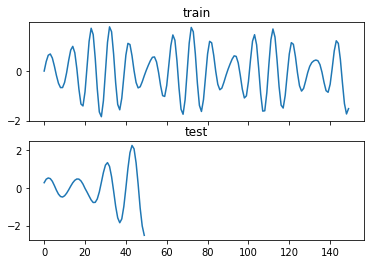

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(signal_decomposed_X[:3].sum(0))
axes[0].set_title('train')
axes[1].plot(signal_decomposed_Z[:2].sum(0))
axes[1].set_title('test')